In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

# Preparing data

In [5]:
URLs.IMDB

'https://s3.amazonaws.com/fast-ai-nlp/imdb'

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/luan/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/luan/.fastai/data/imdb_sample/texts.csv')]

In [7]:
df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [8]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [9]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [10]:
data_lm

TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos xxmaj if you are hoping for xxup anything new , you have chosen the wrong movie . xxmaj who can think that a movie that is a virtual replay of it 's xxunk can be good . xxmaj maybe the producer and maybe the director but hopefully they were not serious when they made this xxup thing . xxmaj this whole movie is like making a greatest hits xxup dvd of the 1st 3 films , but changing the actors . xxup xxunk xxrep 4 a xxup d.,xxbos xxmaj xxunk was great with xxmaj million $ xxmaj hotel . i do n't know how he came up with this film ! xxmaj the idea of giving the situation after xxunk and the view of xxmaj american xxmaj society is xxunk , that makes it 2 out of ten . xxmaj but this is not a movie . xxmaj is that the best someone can do with a great xxunk west - east xxunk are important things going on in middle east and it is just issued on the screen of a xxup mac * with the fingers of an xxmaj xxunk girl who is actually at 

In [11]:
data_lm.save()

In [11]:
data = load_data(path)

# Tokenization

In [15]:
data = TextClasDataBunch.load(path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/luan/.fastai/data/imdb_sample/tmp/itos.pkl'

In [19]:
TextClasDataBunch.load??

## I assume the tokenization already done by the last step?

# Numericalization

Convert tokens from texts

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [13]:
# Look at the train dataset
data.train_ds[0][0]

Text xxbos xxmaj xxunk wasted a lot of xxup tv time talking about the xxmaj xxunk as if they were super xxunk in the dynamics of the modern day xxmaj puerto xxmaj rican . xxmaj they were not . xxmaj the truth is that the xxmaj africans and the xxmaj spanish were and she knows it . xxmaj what kills me is that she is standing on the screen looking like some average light skin black chick ( with an obvious black daddy , xxunk and xxunk to truly acknowledge the real essence of what makes them the modern day xxmaj puerto xxmaj ricans , but barely mentioned how xxmaj africans influenced the way their xxmaj spanish is spoken , the food and music . xxmaj she is so typical and i lost a lot of respect for her and will not support anything else she does . xxmaj also , since she wants to dance around her xxmaj african - ness then she need not take more roles associated with xxunk ( i.e. xxmaj xxunk xxmaj blues ) . xxmaj we can find a xxunk xxmaj black xxmaj latina next time ( thank you xxmaj zoe x

In [14]:
data.train_ds[0][0].data[:10]

array([   2,    4,    0, 1227,   12,  200,   13,    5,  257,   76])

In [16]:
# new way to get the data?
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

# Train full dataset. Language model

In [14]:
bs=48

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/luan/.fastai/data/imdb/models'),
 PosixPath('/home/luan/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/luan/.fastai/data/imdb/unsup'),
 PosixPath('/home/luan/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/luan/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/luan/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/home/luan/.fastai/data/imdb/test'),
 PosixPath('/home/luan/.fastai/data/imdb/README'),
 PosixPath('/home/luan/.fastai/data/imdb/train'),
 PosixPath('/home/luan/.fastai/data/imdb/tmp_clas')]

In [16]:
(path/'train').ls()

[PosixPath('/home/luan/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/luan/.fastai/data/imdb/train/neg'),
 PosixPath('/home/luan/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/luan/.fastai/data/imdb/train/pos')]

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [18]:
#When load again
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [21]:
# Notice no labels
data_lm.show_batch()

idx,text
0,"xxmaj grant , xxmaj irene xxmaj dunne and xxmaj ralph xxmaj bellamy , all of whom are sorely missed . xxmaj and director xxmaj alexander xxmaj hall is no xxmaj leo mccarey either . \n \n xxmaj the principal actors look desperate , and flail around ineffectually . xxmaj the songs are weak , but mercifully short . xxmaj in order not to make xxmaj jane xxmaj wyman look"
1,"you go . \n \n xxmaj about the only thing they kept even remotely close to the games was xxmaj chun xxmaj li 's father is taken by xxmaj bison ... that 's right , taken , not killed . xxmaj balrog is a big black guy xxrep 4 . and xxmaj vega wears a mask and claws xxrep 4 . albeit a shiny silver mask that makes him"
2,"( xxup nj ) xxmaj film xxmaj society last night . xxmaj but i was pleasantly surprised . xxmaj joey "" xxmaj pants "" is actually restrained in this role , and is n't his typical over - the - top screaming character . xxmaj all the other performances are also quite strong , especially xxmaj boyd xxmaj gaines . xxmaj normally , a film where people are wallowing in"
3,"sort of storm - disaster movie , no matter how stupid . xxmaj but this one not only wasted the fifteen minutes i spent watching it , it 's compelling me to waste yet more time writing this review . xxmaj that 's how strongly i feel about it . \n \n xxmaj in this day and age , with so many weather websites available , there 's no"
4,"it may have something to do with the fact that xxmaj harry is ( marginally ) the more subtle of the two characters . \n \n xxbos i saw this one when i was in high school . i had been warned ahead of time , but i liked classical music , including xxmaj grieg , and ignored the warnings . i remember several things about it that really"


In [22]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


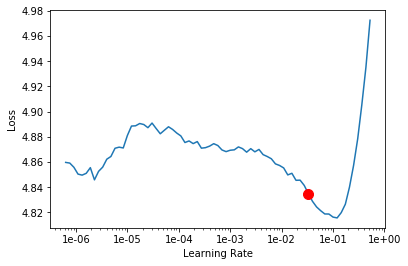

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8, 0.7) )

epoch,train_loss,valid_loss,accuracy
1,4.194761,4.060237,0.293319


In [26]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.928193,3.887591,0.310765
2,3.860478,3.819380,0.320195
3,3.820737,3.774487,0.325908
4,3.760390,3.734528,0.330223
5,3.703763,3.702564,0.334201
6,3.651171,3.680817,0.336432
7,3.580602,3.662767,0.338763
8,3.540569,3.651086,0.340330
9,3.469224,3.646569,0.340969
10,3.469156,3.646400,0.340921


In [29]:
learn.save('fine_tuned')

In [23]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj wow ! xxmaj here it is . xxmaj very likely the worst movie i have ever seen . i had read about this film long ago but never seen it . xxmaj what was going on ( if anything ) in the minds of the people involved ? xxmaj this must be the movie which inspired " xxmaj showgirls " . i thought that was the worst until i watched this . xxmaj no wonder so many actors ' careers seemed to end with this one . i finally understand he meaning of " bad taste " . xxmaj phew - quel stinko !,xxbos a limp musical remake of one of the great screwball comedies of all time , " xxmaj the xxmaj awful xxmaj truth , " this film is a inadvertent valentine to xxmaj cary xxmaj grant , xxmaj irene xxmaj dunne and xxmaj ralph xxmaj bellamy , all of whom are sorely missed . xxmaj and director xxmaj alexander xxmaj hall is no xxmaj leo mccarey either . 
 
  xxmaj the principal actors look desperate , and flail around ineffe

# Try to predict something

In [26]:
TEXT = 'I liked this movie because '
N_WORDS = 50
N_SENTENCES = 2

In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because  for Group Apartment and i think i : n't get show it . This is the because film i have ever seen , and i have seen a same of Group Apartment / but both have great latter mother and are just so great ,
I liked this movie because  and that 's should i love it . i 've where seen such a okay movie . i always it again minutes later , more i was young , a very fiction remember . Now i 'm not middle this movie is good , but i have n't seen


In [28]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [6]:
bs = 48

In [7]:
path = untar_data(URLs.IMDB)

In [7]:
# New databunch with unlablled data
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

NameError: name 'data_lm' is not defined

In [8]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [9]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj that word ' xxmaj true ' in this film 's title got my alarm bells ringing . xxmaj they rang louder when a title card referred to xxmaj america 's xxmaj civil xxmaj war as the ' xxmaj war xxmaj between the xxmaj states ' ( the xxunk preferred by die - hard southerners ) . xxmaj jesse xxmaj james -- thief , slave - holder and murderer",neg
"xxbos xxmaj in his 1966 film "" xxmaj blow xxmaj up "" , xxmaj antonioni had his hero question truth against a backdrop of xxmaj british youth protesters . xxmaj by setting such questions against a fabric of hippie youth movements , xxmaj antonioni questioned , intentionally or not , the effectiveness of these organisations . xxmaj how can you fight for a cause when what you think is true",neg
"xxbos xxmaj such a joyous world has been created for us in xxmaj pixar 's a xxmaj bug 's xxmaj life ; we 're immersed in a universe which could only be documented this enjoyably on film , but more precisely a universe which could only be documented through the world of animation . xxmaj for those who have forgotten what a plentiful and exuberant world animation can offer ",pos
"xxbos i did not know for some time in my youth all that could in general be known about this film however the ways of making a film was not what in fact drew my attention , what made this motion picture one the most liked films even to this very day that i have ever seen was of the xxmaj heroism , bravery and the xxmaj honor to have",pos


In [10]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06


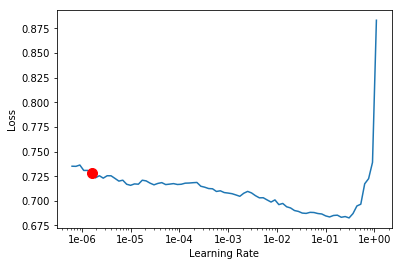

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, 5e-3, moms=(0.8,0.7)) # should been 2e-03

epoch,train_loss,valid_loss,accuracy
1,0.609137,0.531822,0.732200
2,0.609054,0.518151,0.754560
3,0.606977,0.508126,0.751240
4,0.589048,0.494759,0.759240
5,0.597369,0.499961,0.756920


In [35]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.578152,0.500925,0.755840
2,0.594135,0.499039,0.754760
3,0.599084,0.507471,0.752160
4,0.601108,0.504388,0.759360
5,0.591623,0.490699,0.761840
6,0.595263,0.500794,0.756320
7,0.580412,0.525308,0.740120
8,0.584556,0.493864,0.759400
9,0.580776,0.494565,0.760840
10,0.592495,0.496698,0.759240


In [36]:
learn.save('first')

In [10]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj admittedly , i did n't have high expectations of " xxmaj corky xxmaj romano . " xxmaj but then again , who did ? xxmaj however , i felt it deserved the benefit of the doubt . i had no high hopes of " xxmaj joe xxmaj dirt " either -- another recent comedy starring an xxup snl cast member -- and i ended up being pleasantly surprised . xxmaj but this film is just as bad as it looks in the previews . xxmaj chris xxmaj kattan is actually a talented comic actor -- contrary to what you might think after watching this movie -- with great energy . xxmaj he 's been in many hilarious xxup snl skits , and i think he 's one of the most talented cast members on xxup snl as of now . xxmaj in this case , he 's given a lame , pointless script and he tries to remedy each scene with his incessant mugging . xxmaj throughout each scene , he attempts a lame xxmaj jerry xxmaj lewis act and fails miserably . xxmaj jerry

In [11]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.563175,0.487467,0.762000
2,0.506981,0.415070,0.807200
3,0.419202,0.342485,0.856160
4,0.365104,0.308282,0.873440
5,0.338487,0.286196,0.880240
6,0.311128,0.282427,0.885480
7,0.280716,0.293850,0.885320


In [12]:
learn.save('second')

In [11]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj admittedly , i did n't have high expectations of " xxmaj corky xxmaj romano . " xxmaj but then again , who did ? xxmaj however , i felt it deserved the benefit of the doubt . i had no high hopes of " xxmaj joe xxmaj dirt " either -- another recent comedy starring an xxup snl cast member -- and i ended up being pleasantly surprised . xxmaj but this film is just as bad as it looks in the previews . xxmaj chris xxmaj kattan is actually a talented comic actor -- contrary to what you might think after watching this movie -- with great energy . xxmaj he 's been in many hilarious xxup snl skits , and i think he 's one of the most talented cast members on xxup snl as of now . xxmaj in this case , he 's given a lame , pointless script and he tries to remedy each scene with his incessant mugging . xxmaj throughout each scene , he attempts a lame xxmaj jerry xxmaj lewis act and fails miserably . xxmaj jerry

# Continue training. Modify bach size to fit in GPU

In [12]:
# Modify the bach size
bs = 30
learn.data.batch_size = bs

In [13]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.355103,0.299147,0.872800
2,0.527454,0.358387,0.835640
3,0.426946,0.314960,0.864320
4,0.421342,0.303351,0.871920


In [14]:
learn.save('third')

In [11]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj admittedly , i did n't have high expectations of " xxmaj corky xxmaj romano . " xxmaj but then again , who did ? xxmaj however , i felt it deserved the benefit of the doubt . i had no high hopes of " xxmaj joe xxmaj dirt " either -- another recent comedy starring an xxup snl cast member -- and i ended up being pleasantly surprised . xxmaj but this film is just as bad as it looks in the previews . xxmaj chris xxmaj kattan is actually a talented comic actor -- contrary to what you might think after watching this movie -- with great energy . xxmaj he 's been in many hilarious xxup snl skits , and i think he 's one of the most talented cast members on xxup snl as of now . xxmaj in this case , he 's given a lame , pointless script and he tries to remedy each scene with his incessant mugging . xxmaj throughout each scene , he attempts a lame xxmaj jerry xxmaj lewis act and fails miserably . xxmaj jerry

In [12]:
bs = 17
learn.data.batch_size = bs

In [13]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.388331,0.295844,0.872280
2,0.389355,0.324385,0.873520
3,0.347947,0.277922,0.885920
4,0.353919,0.264901,0.889920
5,0.300959,0.260551,0.893600
6,0.318198,0.255544,0.895000
7,0.290724,0.254245,0.895560
8,0.280921,0.258811,0.893560
